# Project: **Finding Lane Lines on the Road** 


**The tools you have are: 

* color selection, 
* region of interest selection, 
* grayscaling, 
* Gaussian smoothing, 
* Canny Edge Detection and 
* Hough Tranform line detection.  

You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
#import os
#os.listdir("test_images/")

## Tmp Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


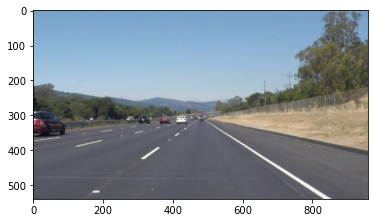

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#create a copy of original image
#gray = np.copy(image)
#plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [17]:
import math

def getROIVertices(img):
    """
    'img' reference image used to get its shape
    returns the vertices of the ROI trapezoid
    """  
    
    #lower left corner of Trapezoid
    P1 = (0,img.shape[0])#((int(round(img.shape[1]*0.3)),img.shape[0]))
    #upper left corner of Trapezoid
    P2 = (int(round(img.shape[1]*0.45)), int(round(img.shape[0]*.6))) #(430,330)
    #upper right corner of Trapezoid
    P3 = (int(round(img.shape[1]*0.58)), int(round(img.shape[0]*.6)))#
    #lower right corner of Trapezoid
    P4 = (img.shape[1],img.shape[0])
    
    return np.array([[P1,P2, P3,P4]], dtype=np.int32)

    
def applyColorMasks(img,lower_white,upper_white,lower_yellow, upper_yellow):
    """
    'img' image to apply the masks to 
        use inrange to create yellow and white masks
        apply the masks to the input image
    """    
    # Convert to HSV color space
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Threshold the HSV image - white range
    mask1 = cv2.inRange(hsv, lower_white, upper_white)
    # Threshold the HSV image - yellow range
    mask2 = cv2.inRange(hsv, lower_yellow, upper_yellow)

    ## final mask and masked
    mask = cv2.bitwise_or(mask1, mask2)
    target = cv2.bitwise_and(img,img, mask=mask)
    return target

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img,ROIvertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `ROIvertices`. The rest of the image is set to black.
    """   
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255      
    
    #filling pixels inside the polygon defined by "ROIvertices" with the fill color    
    cv2.fillPoly(mask, ROIvertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, ROIvertices, color=[255, 0, 0], thickness=10):
    """
    'img'       input image to use as background. Lines are drawn on the image inplace (mutates the image).
    'lines'     lines to draw 
    'color'     line color
    'thickness' thickness of the line
    """
    if lines is None:
        return 0
    if len(lines)==0:
        return 0
        
    # reference y values for the two lines
    #y_min is 5% inside the ROI
    y_min = ROIvertices[0][1][1]+int(round(.05*img.shape[0]))
    y_max= img.shape[0]
    
    #right line
    pos_coords_x = []
    pos_coords_y = []
    
    #left line
    neg_coords_x = []
    neg_coords_y = []
    
    for line in lines:
        
        for x1,y1,x2,y2 in line:
            
            #evaluate line params
            slope = ((y2-y1)/(x2-x1))
            intercept = y1-slope*x1
            
            #discard outliers
            if(abs(slope) >= 0.6 and abs(slope) <= 0.8):
                if (slope>0):
                    if (draw_raw_lines):
                        cv2.line(img, (x1, y1), (x2, y2), color, 2)
                    pos_coords_x.append(x1)
                    pos_coords_y.append(y1)
                    pos_coords_x.append(x2)
                    pos_coords_y.append(y2)                    
                else:
                    if (draw_raw_lines):
                        cv2.line(img, (x1, y1), (x2, y2), color, 2)
                    neg_coords_x.append(x1)
                    neg_coords_y.append(y1)
                    neg_coords_x.append(x2)
                    neg_coords_y.append(y2)  
                    
             
    #draw right line         
    right_line_fitted = getFittingLine(pos_coords_y,pos_coords_x)

    if(right_line_fitted != -1):
        y1=y_min
        x1=int(right_line_fitted(y1))
        y2=y_max
        x2=int(right_line_fitted(y2))

        if (draw_raw_lines==False):
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

        
    #draw left line

    left_line_fitted = getFittingLine(neg_coords_y,neg_coords_x)
    
    if(left_line_fitted != -1):       
        y1=y_min
        x1=int(left_line_fitted(y1))
        y2=y_max
        x2=int(left_line_fitted(y2))

        
        if (draw_raw_lines==False):
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

     
def getFittingLine(x,y):
    if len(x) >0 and len(y)>0:
        return np.poly1d(np.polyfit(x,y,deg=1))
    else:
        return -1
        
    
def hough_lines(img,ROIvertices, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,ROIvertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def img_info(img,show):
    """
    some info about the image useful for quick checks
    `img` is the input image 
    `show` if True, plot the image 
    """
    print('This image is:', type(img), 'with dimensions:', img.shape)
    if (show):
        plt.imshow(img, cmap='gray')

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

#image = mpimg.imread('test_images/test.jpg')

# Define range of white color in HSV
lower_white = np.array([0, 0, 212])
upper_white = np.array([131, 255, 255])
lower_yellow = np.array([0,0,0])
upper_yellow = np.array([36, 255, 255])

## parameters
blur_kernel_size = 9
canny_low_threshold = 90
canny_high_threshold = 200



hough_rho = 4    # distance resolution in pixels of the Hough grid
hough_theta = np.pi/90   # angular resolution in radians of the Hough grid
hough_threshold = 100      # minimum number of votes (intersections in Hough grid cell)
hough_min_line_len = 5    # minimum number of pixels making up a line
hough_max_line_gap = 1    # maximum gap in pixels between connectable line segments

merge_alpha=0.8
merge_beta=1. 
merge_gamma=0.

#switch for drawing raw data lines
draw_raw_lines = False

#parameters uses for still images
input_folder = 'test_images/'
output_folder = 'test_images_output/'
filename = ''


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
        
    # 1) apply color selection   
    img_w= applyColorMasks(np.copy(image),lower_white,upper_white,lower_yellow, upper_yellow)
    #img_info(img_w,True)
    
    #2) get RoIt vertice based on image shape
    RoIvertices = getROIVertices(img_w)
    #print(RoIvertices)
    
    # 3) create gray image
    gray = grayscale(img_w)
    #gray = grayscale(np.copy(image))
    #img_info(gray,True)

    # 4) apply gaussian blur
    blurred_img = gaussian_blur(gray,blur_kernel_size)
    #img_info(blurred_img,True)

    # 5) detects edges
    edges = canny(blurred_img, canny_low_threshold, canny_high_threshold)
    #img_info(edges,True)

    # 6) define region of interest (RoI) and apply to image
    
    masked_edges = region_of_interest(edges,RoIvertices)
    #img_info(masked_edges,True)

    # 7) detect lines within RoI & draw detected lines

    lines = hough_lines(masked_edges, RoIvertices, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)
    #img_info(lines,True)
    
    #uncomment the following line to process still images
    #lines = cv2.cvtColor(lines, cv2.COLOR_RGB2BGR)

    # 8) overlay the detected lanes with the original image

    merged = weighted_img(lines, image, α=merge_alpha, β=merge_beta, γ=merge_gamma)
    #img_info(merged,True)

    # Filename 
    # Saving the still images 
    cv2.imwrite(output_folder+filename, merged) 
    return merged


 test_images/solidYellowCurve.jpg

 test_images/solidYellowLeft.jpg

 test_images/solidYellowCurve2.jpg

 test_images/solidWhiteRight.jpg

 test_images/whiteCarLaneSwitch.jpg

 test_images/solidWhiteCurve.jpg


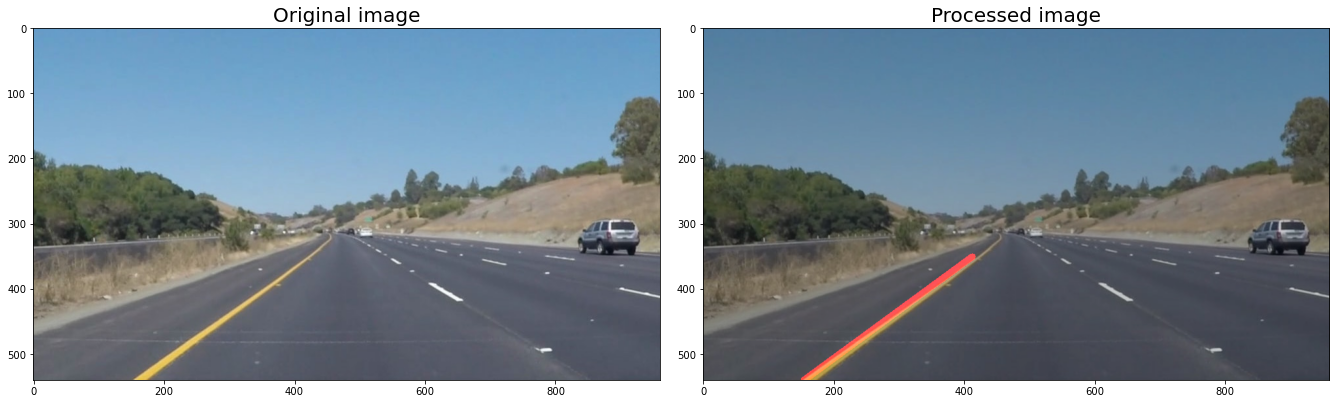

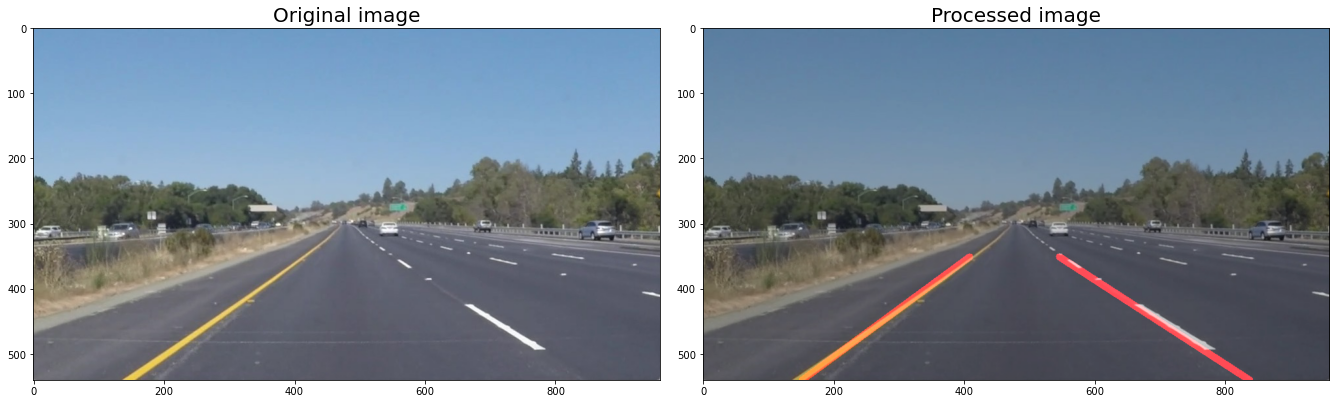

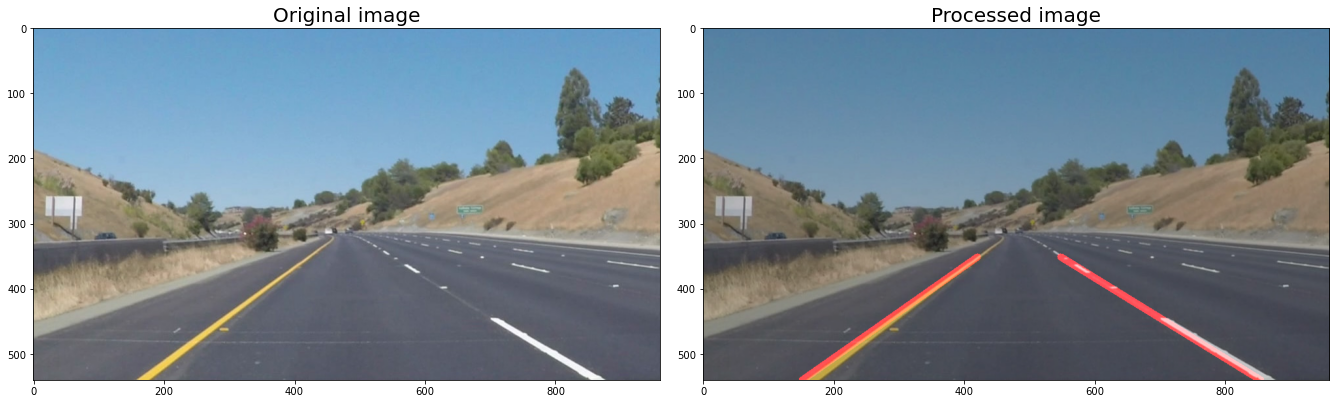

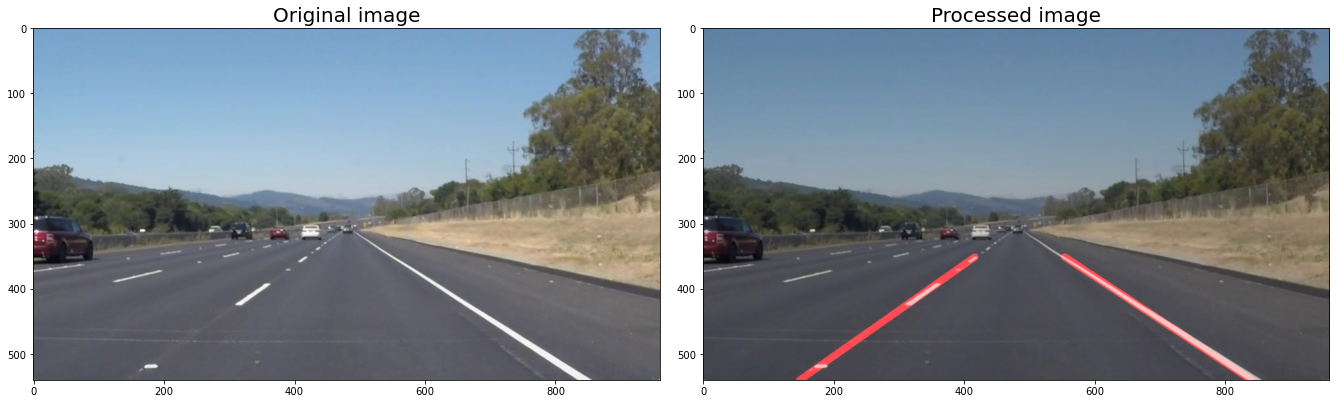

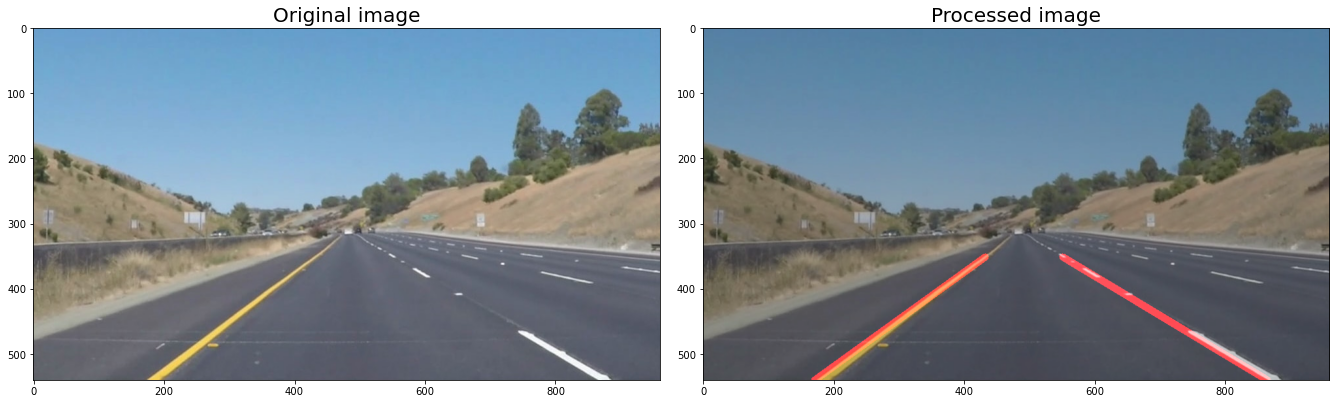

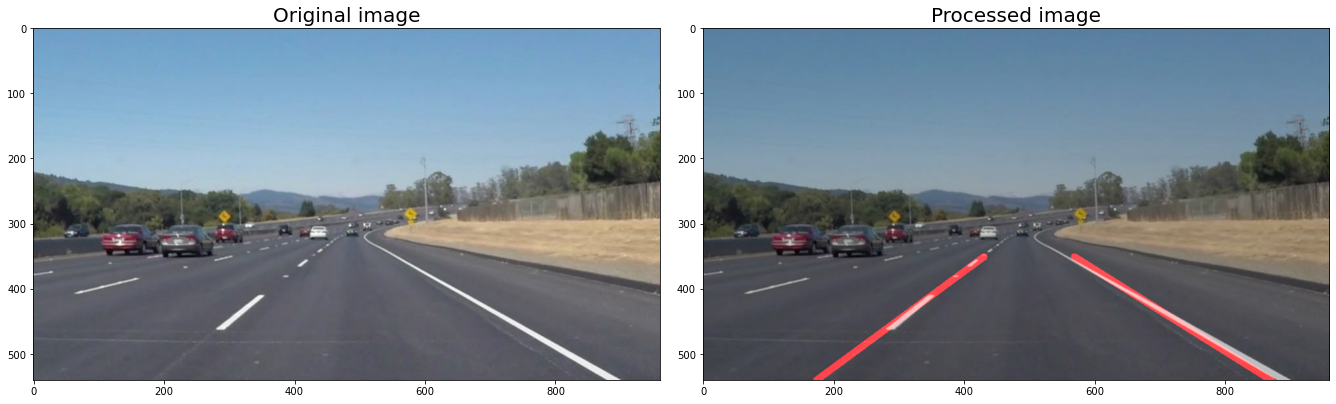

In [36]:
def writeup_plot_test_images(folder=''):
    
    '''
    method: generates images for the project writeup 
    '''    
    
    root_path = 'test_images/'
    path = root_path + folder

    full_path = path + '*.jpg'


    images = glob.glob(full_path)    

    for im in images:    


        #image = cv2.imread(input_folder+filename)
        image = mpimg.imread(im)
        print("\n",im)
        processed_img = process_image(image)


        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(18, 7))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original image', fontsize=20)


        ax2.imshow(processed_img)
        ax2.set_title('Processed image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.05,wspace = None,hspace = 0.3)


        # Save the full figure...
        final_name = 'test_images_output/{}_processed.jpg'.format(im.split('.')[0].split('/')[1])
        
        f.savefig(final_name)


writeup_plot_test_images()

In [35]:
txt  = 'test_images/solidYellowCurve.jpg'
txt.split('.')[0].split('/')[1]

'solidYellowCurve'

Let's try the one with the solid white lane on the right first ...

In [15]:
video_filename= 'solidWhiteRight.mp4'
video_output_folder = 'test_videos_output/'
video_input_folder = 'test_videos/'
white_output = video_output_folder+video_filename
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(video_input_folder+video_filename).subclip(0,5)
clip1 = VideoFileClip(video_input_folder+video_filename)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|▏         | 5/221 [00:00<00:04, 44.34it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 8.42 s, sys: 561 ms, total: 8.98 s
Wall time: 9.03 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))